### Late Fusion with TL ###

In the first cell all the necessary packages are imported.
OS packages is used to loop into directories and to handle the cuda visibility.
tensorflow is the deep learning libray that includes also keras.
Image is used to display the cnn architecture.
CNNUtilities class includes methods that loads images, re-built predicted images.
FusionWithVGG includes the functions relates to create and instantiate CNNs with VGG16 (Transfer learning is used here)

In [9]:
import os
import tensorflow as tf
from IPython.display import Image
from Utilities.utilities import CNNUtilities
from Utilities.FusionWithTL import FusionWithVGG

configuration is a dictionary that includes variables such as image width, image height, etc.

In [10]:
configuration = {
    "VERBOSE": False,
    "GPU": False,
    "image_height": 224,
    "image_width": 224,
    "epochs": 10
}

segmentation_index = [0, 1020, 1377, 240, 735, 2380]

The next cell is used to handle cuda visibility. Setting the configuration GPU to false in configuration, system switch to cpu

In [11]:
print(f'[CONFIGURATION] Actual configuration {configuration}')

if not configuration['GPU']:
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
else:
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
    for i in range(len(physical_devices)):
        tf.config.experimental.set_memory_growth(physical_devices[i], True)

[CONFIGURATION] Actual configuration {'VERBOSE': False, 'GPU': False, 'image_height': 224, 'image_width': 224, 'epochs': 10}


This cell utility object is created. The target height and the target width are instantiated as well.

In [12]:
# create utility instance
utilities = CNNUtilities(configuration=configuration,
                         segmentation_index_list=segmentation_index)

# get height and width of the image
h = configuration["image_height"]
w = configuration["image_width"]

# define the var for the final shape
image_shape = (h, w)

Thanks to the utility object, now it is possible to call a methods that load:
- RGB images (200 for train 100 for test and 66 for validation)
- NIR images (200 for train 100 for test and 66 for validation)
- Labels (200 for train 100 for test and 66 for validation) divided in 6 class

Each of the called functions load two sets of numpy arrays with the following shape (number of samples, height of image, width of image and channel of the image)
for the rgb images and the nir images. The labels contain the GT pixels' map.

In [13]:
# first step load the datasets
train_rgb, train_depth, train_labels = utilities.load_the_image_from_the_dataset_folder(path="../Dataset/train",
                                                                                        image_shape=image_shape)

print(f"[TRAIN] RGB {train_rgb.shape} NIR {train_depth.shape} LABEL {train_labels.shape}")

test_rgb, test_depth, test_labels = utilities.load_the_image_from_the_dataset_folder(path="../Dataset/test",
                                                                                     image_shape=image_shape)

print(f"[TEST] RGB {test_rgb.shape} NIR {test_depth.shape} LABEL {test_labels.shape}")

validation_rgb, validation_depth, validation_labels = utilities.load_the_image_from_the_dataset_folder(path="../Dataset/valid",
                                                                                                       image_shape=image_shape)

print(f"[VALIDATION] RGB {validation_rgb.shape} NIR {validation_depth.shape} LABEL {validation_labels.shape}")

[TRAIN] RGB (200, 224, 224, 3) NIR (200, 224, 224, 3) LABEL (200, 50176, 6)
[TEST] RGB (100, 224, 224, 3) NIR (100, 224, 224, 3) LABEL (100, 50176, 6)
[VALIDATION] RGB (66, 224, 224, 3) NIR (66, 224, 224, 3) LABEL (66, 50176, 6)


Here a dictionary with the necessary Hyper parameters for the CNN is created. They respectively contains:
- the input shape of the rgb input and nir input
- the kernel size for the rbg and nir convolution layers
- A list of number of units of each convolution layer
- the dropout value (None if not needed)
- number of output class for softmax

In [14]:
# create cnn config
cnn_configuration = {
    'shape_stream_rgb': train_rgb.shape[1:],
    'kernel_size_stream_rgb': (train_rgb.shape[3], train_rgb.shape[3]),
    'shape_stream_nir': train_depth.shape[1:],
    'kernel_size_stream_nir': (train_depth.shape[3], train_depth.shape[3]),
    'list_of_conv_layers': [128, 256],
    "dropout": 0.2,
    'number_of_classes': len(segmentation_index)
    }

print(f'[CNN CONFIGURATION] {cnn_configuration}')

[CNN CONFIGURATION] {'shape_stream_rgb': (224, 224, 3), 'kernel_size_stream_rgb': (3, 3), 'shape_stream_nir': (224, 224, 3), 'kernel_size_stream_nir': (3, 3), 'list_of_conv_layers': [128, 256], 'dropout': 0.2, 'number_of_classes': 6}


Due to the multiples inputs of the CNN, the sets are prepared in dictionaries.

In [15]:
# prepare dicts of data
# for train
dictionary_of_training = {
    'input_rgb': train_rgb,
    'input_nir': train_depth
}
# for test
dictionary_of_test = {
    'input_rgb': test_rgb,
    'input_nir': test_depth
}
# for validation
dictionary_of_validation = {
    'input_rgb': validation_rgb,
    'input_nir': validation_depth
}

The CNN handler object is instantiated with the dictionary of parameters created before.
- In this case late fusion is called.
- The network is compiled with SGD function
- The loss function is categorical cross entropy

In [16]:
# instance of the model
cnn_handler = FusionWithVGG(**cnn_configuration)

# create a late fusion
cnn_handler.late_fusion()

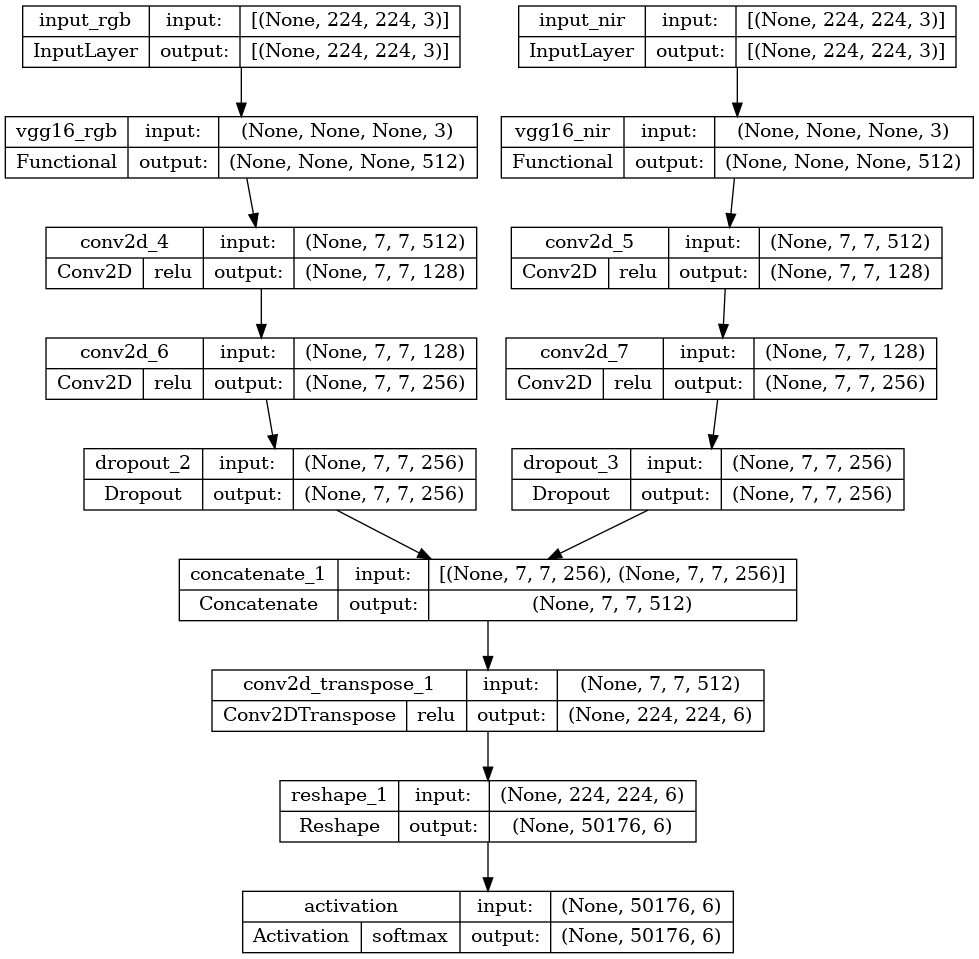

In [17]:
cnn_handler.plot_the_model("images/cnn_late_fusion.png")
Image('images/cnn_late_fusion.png')

The model is trained on the “train” dataset  and “validation” dataset for 10 epochs.

In [18]:
# fit the model
cnn_handler.fit_the_model(x_train=dictionary_of_training,
                          y_train=train_labels,
                          x_validation=dictionary_of_validation,
                          y_validation=validation_labels,
                          epochs=configuration["epochs"])


Epoch 1/10
100/100 [==============================] - 141s 1s/step - loss: 0.4238 - accuracy: 0.4488 - val_loss: 0.5171 - val_accuracy: 0.6282
Epoch 2/10
100/100 [==============================] - 142s 1s/step - loss: 0.1983 - accuracy: 0.8084 - val_loss: 0.1743 - val_accuracy: 0.8891
Epoch 3/10
100/100 [==============================] - 143s 1s/step - loss: 0.1411 - accuracy: 0.8856 - val_loss: 0.1742 - val_accuracy: 0.9056
Epoch 4/10
100/100 [==============================] - 144s 1s/step - loss: 0.1233 - accuracy: 0.9028 - val_loss: 0.1287 - val_accuracy: 0.9111
Epoch 5/10
100/100 [==============================] - 143s 1s/step - loss: 0.1138 - accuracy: 0.9136 - val_loss: 0.1366 - val_accuracy: 0.9187
Epoch 6/10
100/100 [==============================] - 142s 1s/step - loss: 0.1032 - accuracy: 0.9237 - val_loss: 0.1212 - val_accuracy: 0.9264
Epoch 7/10
100/100 [==============================] - 142s 1s/step - loss: 0.0962 - accuracy: 0.9293 - val_loss: 0.1223 - val_accuracy: 0.9251

The model is evaluated on the test dataset.

In [19]:
# evaluate the model
cnn_handler.evaluate_the_model(x_test=dictionary_of_test,
                               y_test=test_labels)


4/4 [==============================] - 17s 4s/step - loss: 0.0823 - accuracy: 0.9285
[SCORES] The score is 92.84951090812683


The model make prediction with the test dataset that is not seen during the training phase.

In [20]:
# predict
final_predictions = cnn_handler.make_predictions(x_test=dictionary_of_test)


4/4 [==============================] - 18s 4s/step


The predicted array is converted to images.

In [21]:
# loop into the prediction arrays and rebuilt the image
final_list_of_results = list()

for predicted_index in range(final_predictions.shape[0]):
    temp = utilities.convert_the_prediction(prediction=final_predictions[predicted_index, :, :],
                                            number_of_classes=len(segmentation_index),
                                            height_of_predicted_image=h,
                                            width_of_pred_image=w)
    # append the result to list
    final_list_of_results.append(temp)


Show first nine images

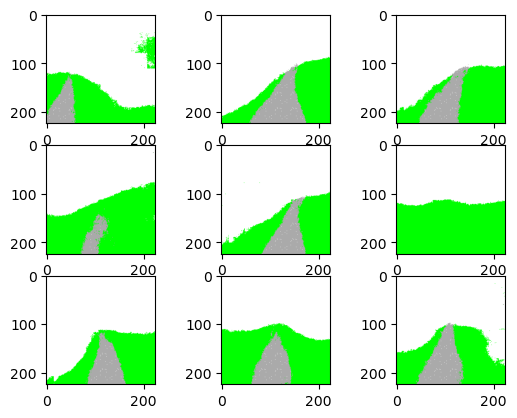

In [22]:
# now plot here the images
utilities.plot_some_images(how_many_rows=3, how_many_cols=3, list_of_element_to_plot=final_list_of_results)